In [1]:
from importlib import reload
import os
import numpy as np
import time
from tqdm import trange
from pulsestreamer import *
from nidaqmx import *

import analysis
reload(analysis)
from analysis import *

import measurement
reload(measurement)
from measurement import *

In [2]:
# loading the local Pulse Streamer and NIDAQmx
IPaddress = findPulseStreamers(search_serial='')[0][0]
pulser = PulseStreamer(IPaddress)

DAQ_device = nidaqmx.system.System.local().devices[0]
device_name = DAQ_device.terminals[0:1][0][1:5]
print(f'NIDAQmx device name : {device_name}')

Connect to Pulse Streamer via JSON-RPC.
IP / Hostname: 169.254.8.2
Pulse Streamer 8/2 firmware: v1.7.2
Client software: v1.7.0
NIDAQmx device name : Dev1


In [118]:
specs_ports = {'laserNum' : 1, 'gateStart' : 5, 'source' : 7}

specs_delay = {'rising_delay' : 2,'gatelen' :  6, 'laserontime' :  31,'delay_pad' :  2,
               'delay_shift' :  2,'gatesourcedelay' : 2}
specs_t1 = {'rising_delay' : 20,'gatelen' : 1.5e3, 'laserontime' : 25e3,'delay_pad' : 20,
            'delay_shift' : 50e3,'gatesourcedelay' : 5,'evolution_time' : 0.5e6}
specs_snr = {'rising_delay' : 20,'gatelen' : 1.5e3, 'laserontime' : 20e3,'delay_pad' : 20,
             'delay_shift' : (20e3-1.5e3)/10,'gatesourcedelay' : 5,'evolution_time' : 1.0e6}
specs_snr_new = {'rising_delay' : 20,'gatelen' : 1.5e3, 'laserontime' : 20e3,'delay_pad' : 20,
             'delay_shift' : (20e3-1.5e3)/10,'gatesourcedelay' : 5,'evolution_time' : 1e6}

specs_lifetime = {'rising_delay' : 2,'gatelen' : 2, 'laserontime' : 25,'laserofftime' : 50,
                  'delay_pad' : 2,'delay_shift' : 2,'gatesourcedelay' : 2}  
specs_t1_ir = {'rising_delay' : 20,'gatelen' : 2e3, 'laserontime' : 25e3,'delay_pad' : 20,
            'delay_shift' : 45e3,'gatesourcedelay' : 5,'evolution_time' : 0.45e6,'irontime' : 1e3,'irport' : 3}
specs_t1_simple = {'rising_delay' : 10,'gatelen' : 3e3, 'laserontime' : 1000e3,'delay_pad' : 10,
            'delay_shift' : 25e3,'gatesourcedelay' : 5,'evolution_time' : 0.25e6,'first_time': 1e3}
specs_t1_new = {'rising_delay' : 20,'gatelen' : 0.5e3, 'laserontime' : 1000e3,'delay_pad' : 20,
            'delay_shift' : 35e3,'gatesourcedelay' : 5,'evolution_time' : 0.35e6}

In [120]:
exp_name = "t1_simple"
samples = 2000
averages = 5
inside_folders=["MD",f"{exp_name}","525nm_(wout_1064nm)","with_Gd_FeUCP","0.1M_15%"]
first_sig_ref = "signal"

In [122]:
total_specs = merge(specs_ports,globals()["specs_"+exp_name])

In [124]:
# plot_sequence(pulser=pulser,exp_name='t1_simple',specifications=total_specs)
# get_time(pulser=pulser,exp_name='t1_simple',specifications=total_specs)

In [ ]:
avg_data,time_axis = measure(pulser,DAQ_device,device_name,exp_name = exp_name,
                   samples=samples,averages=averages,specifications=total_specs)

number of steps : 11
Pixel : 44000
creating sequence
starting DAQ
Preparing Ni Daq for the experiment
callback number in beginning: 0


  0%|          | 0/5 [00:00<?, ?it/s]

1
2
3
4
5
6
7
8
9
10
11


 20%|██        | 1/5 [00:46<03:05, 46.46s/it]

callback number after 1-th average end: 11
1
2
3
4
5
6
7
8
9
10
11


 40%|████      | 2/5 [01:32<02:19, 46.46s/it]

callback number after 2-th average end: 22
1
2
3
4
5
6
7
8


In [144]:
dict_args = {'avg_data':avg_data,'time_axis':time_axis}

In [146]:
root_directory = os.getcwd()
print(f'root directory : {root_directory}')

root directory : C:\Users\Administrator\OneDrive\Desktop\T1_measurement\atanu_github\Instrument_Automation\Experimental_Applications


In [148]:
year = time.ctime()[-4:]
date = time.ctime()[4:10].replace(' ','_')
current_time = time.ctime()[-13:-8].replace(':','_')

# # folder_path = root_directory+f'/exp_data/{year}/{date}/microdiamonds/t1_simple/525nm/with_Gd_FeUCP/0.1M_15%/avgs_5/samples_2000/laser_1000e3/'
# folder_path = root_directory+f'/exp_data/{year}/{date}/microdiamonds/{exp_name}/525nm/with_Gd_FeUCP/0.1M_15%/avgs_{averages}/samples_{samples}/laser_{globals()['specs_'+exp_name]['laserontime']}/'
# file_name = f'[{current_time}]_gate_{globals()['specs_'+exp_name]['gatelen']}.npz'

initial_path = os.path.join(root_directory, f'exp_data/{year}/{date}')
inside_path = os.path.join(initial_path, *inside_folders)
full_path = os.path.join(inside_path, f'avgs_{averages}', f'samples_{samples}', f'laser_{globals()["specs_"+exp_name]["laserontime"]}')
os.makedirs(full_path, exist_ok=True)

file_name = f'[{current_time}]_gate_{globals()["specs_"+exp_name]["gatelen"]}.npz'

try:
    total_path = npz_save(full_path,file_name,**dict_args)
except Exception as e:
    print(f"An error occurred: \n{e}")
    print("\nPlease reduce the folder_name")

saving data_file '[13_10]_gate_3000.0.npz' is successful!



In [150]:
load_data = dict(np.load(total_path))

In [152]:
time_axis,signal_photon,reference_samples,signal_samples = data_to_time_signal(load_data,samples,first=first_sig_ref)

Lifetime in nano_second is : -1099283481.7 ± 6364533234807.8



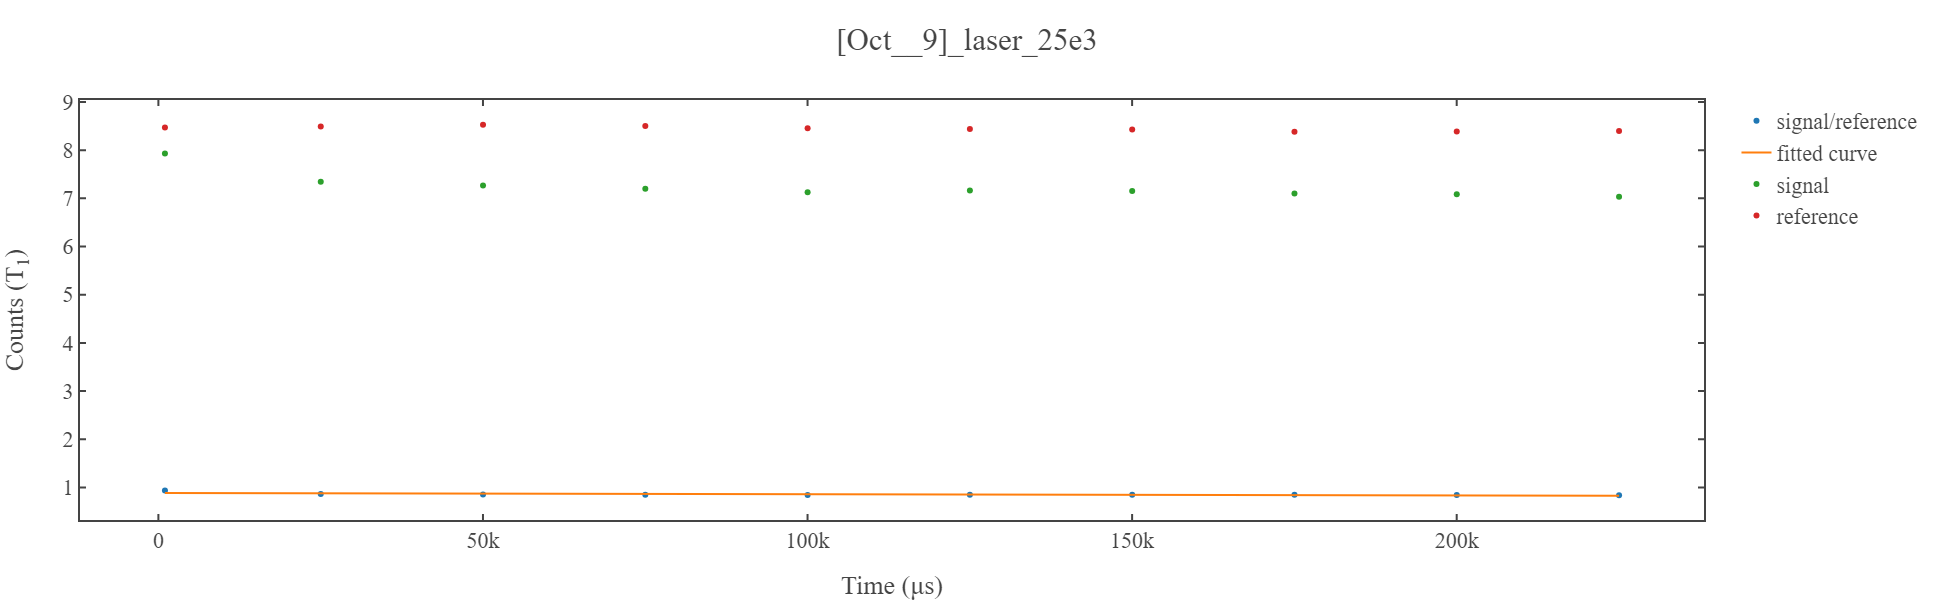

In [156]:
x=time_axis[1:]
y=signal_photon[1:]
# y=signal_photon[1:]
# y=np.concatenate(([0.93], signal_photon[1:]))

x_fit,y_fit,coefficient,error_bars = fit_func(x,y,fit_range=False,func='exp',guess_params=np.array([0.7,1,0.5e6]))

fig1 = simple_plot(x,y,show=False,x_name = "Time (&mu;s)",y_name = "Counts (T<sub>1</sub>)",mode='markers',title=f'{date}',curve_name='signal/reference')
fig2 = simple_plot(x_fit,y_fit,show=False,x_name = "Time (&mu;s)",y_name = "Counts (T<sub>1</sub>)",mode='lines',title=f'{date}',curve_name='fitted curve')
fig3 = simple_plot(x,signal_samples[1:],show=False,x_name = "Time (&mu;s)",y_name = "Counts (T<sub>1</sub>)",mode='markers',title=f'{date}',curve_name='signal')
fig4 = simple_plot(x,reference_samples[1:],show=False,x_name = "Time (&mu;s)",y_name = "Counts (T<sub>1</sub>)",mode='markers',title=f'{date}',curve_name='reference')


add_figures([fig1,fig2,fig3,fig4],show=True,x_name = "Time (&mu;s)",y_name = "Counts (T<sub>1</sub>)",title=f'[{date}]_laser_25e3')

## Add calibrations, specifications and few reference plots

9th of october 2024
laser power= 3.675mW
count =3.9k/sec


1. laserontime_1ms : [83672.7 ± 11132.5,88242.9 ± 9828.2,113852.4 ± 24406.6,120984.2 ± 19452.6]

515nm + 1064nm  
1. without_ir : [17182.9 ± 2558.6,17333.7 ± 4166.4]
2. with_ir : [ref_3.5: , ref_3.0: , ref_2.5: , ref_2.0: ,ref_1.5]

calibration of 1064nm 
1. source_ref : [3.5,3.0,2.5,2.0,1.5]
2. powermeter reading before the intrigated setup : []

oct 8

1. with only thin glass slide without cover slip.
2. laserontime_10e3 : first_ref: [251951.1 ± 27388.1(0.8e6),285761.3 ± 37677.1(0.8e6)], first_sig: [264302.1 ± 30649.9(0.8e6),297461.3 ± 40974.6(0.8e6)]
3. laserontime_5e3 : first_ref: [127480.0 ± 12655.7(0.8e6),128915.8 ± 9179.1(0.8e6),142498.7 ± 28557.6(0.4e6)], first_sig: [131029.5 ± 13367.2(0.8e6),132977.1 ± 9447.1(0.8e6),147831.7 ± 30252.4(0.4e6)]

for Gd experiment, ref is taken evolution time 0.8e6, laserontime 5e3, gatelen 2e3
before : first_ref : [172202.1 ± 5417.1,138590.7 ± 23726.9,132493.7 ± 9739.8,148194.2 ± 12840.9], first_sig : [177283.5 ± 5769.4,145316.0 ± 25042.6,135929.0 ± 10484.0,152301.2 ± 13564.5]
after : 
1. 0.05M, 20 microlitter, first_ref : [160592.5 ± 30852.3,151210.0 ± 26083.0,137432.4 ± 17757.1], first_sig : [168654.0 ± 33735.0,157303.0 ± 27755.1,133391.9 ± 16651.0]
2. 0.1M, 20 microlitter, first_ref : [101578.7 ± 5094.1,97067.2 ± 19504.4], first_sig : [104240.5 ± 5103.9,100572.8 ± 20485.5] (cluster mistakenly changed)
3. 0.1M, 20 microlitter, with 15% FeUCP, first_ref : [133848.9 ± 45117.5,100753.3 ± 12875.5], first_sig : [136369.4 ± 47799.0,102649.8 ± 13728.5] (with chnged cluster)

oct 5 

only microdiamonds with t1 sequence
1. laserontime_25e3 : [71854.3 ± 29925.6,46497.9 ± 12325.3] (sig and sig/ref are exponentially increasing but ref is decreasing. However, now the ref is more than sig and almost constant. Sig has not achieved the steady value.)
2. laserontime_20e3 : [54644.0 ± 20095.1, 54254.2 ± 19319.4] (similar to 25e3.)
3. laserontime_15e3 : [224465.4 ± 227911.2,373035.0 ± 653140.6] (similar to previous cases, although now sig and ref are approching each other slowly.)
4. laserontime_10e3 : [1342262815.2 ± 1463551777574.4,29033569.0 ± 2795046276.8] (they approched more and now it seems there is some transition happening.)
5. laserontime_5e3 : [58447.4 ± 7026.0, 53774.8 ± 5919.2] (now ref crossed sig with similar features of others.)
6. laserontime_4e3 : [75602.1 ± 14953.5,66403.5 ± 18132.0] (ref is inside of sig)
7. laserontime_3e3 : [43610.4 ± 10700.5, 43051.9 ± 5937.5] (ref is in the middle of sig and sig has gone more scattered.)